In [ ]:
import sys
sys.path.append("../utils")
from utils import load_data
from vae import VAE
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Import Keras for implementing autoencoders
import keras
from keras.models import Sequential
from keras.layers import Input, Dense
from pathlib import Path
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import torch


2024-12-02 21:36:57.949451: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
train, test, train_target = load_data()

# Data Augmentation

In [16]:
# Add the project root directory to the Python path
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))
# Load the data
data_path = project_root / 'data' / 'preprocessed'
train_augmented = pd.read_csv(data_path / 'train_augmented.csv')

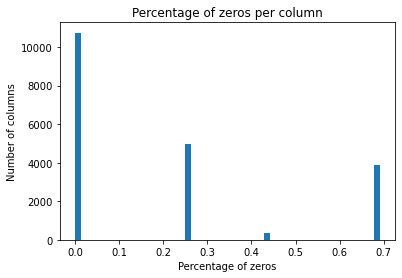

A3GALT2    0.690962
AADACL3    0.690962
AADACL4    0.690962
AARD       0.690962
AARS1      0.690962
             ...   
ZSCAN5B    0.690962
ZSCAN5C    0.690962
ZSWIM4     0.690962
ZSWIM9     0.690962
ZUP1       0.690962
Length: 3879, dtype: float64


In [17]:
# Plot percentage of samples == 0  per columns
percentage_zeros = (train_augmented == 0).mean()
percentage_zeros.plot(kind='hist', bins=50)
plt.xlabel('Percentage of zeros')
plt.ylabel('Number of columns')
plt.title('Percentage of zeros per column')
plt.show()
# Print all columns with more than 40% zeros
print(percentage_zeros[percentage_zeros > 0.6])

In [ ]:
nb_cell_lines = 742
# Get all columns with more than 60% zeros
columns_to_drop = percentage_zeros[percentage_zeros > 0.6].index
# drop these columns
train_augmented = train_augmented.drop(columns=columns_to_drop)
# Split the data between extra data and fine tune data
fine_tune_data = train_augmented[:nb_cell_lines]
extra_data = train_augmented[nb_cell_lines:]

In [19]:
# Split the data
fine_tune_train, fine_tune_test, y_train, y_test = train_test_split(fine_tune_data, train_target, test_size=0.2, random_state=42)
extra_train, extra_test = train_test_split(extra_data, test_size=0.2, random_state=42)

In [20]:
# Define the autoencoder architecture
input_dim = extra_train.shape[1]
encoding_dim = 500

# Set the encoding dimension
input_layer = keras.layers.Input(shape=(input_dim,))
encoder = keras.layers.Dense(encoding_dim, activation="relu")(input_layer)
decoder = keras.layers.Dense(input_dim, activation="sigmoid")(encoder)
autoencoder = keras.Model(inputs=input_layer, outputs=decoder)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Summary of the autoencoder architecture
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16028)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │     8,014,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16028)          │     8,030,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,044,528 (61.21 MB)

 Trainable params: 16,044,528 (61.21 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
autoencoder.fit(extra_train, extra_train, epochs=10, batch_size=32, shuffle=True, validation_data=(extra_test, extra_test))

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 0.9108 - val_loss: 0.8095
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.7894 - val_loss: 0.7784
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.7586 - val_loss: 0.7513
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.7264 - val_loss: 0.7310
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.6980 - val_loss: 0.7181
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 0.6801 - val_loss: 0.7100
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.6605 - val_loss: 0.7030
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.6504 - val_loss: 0.6982
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.6383 - val_loss: 0.6951
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.6314 - val_loss: 0.6930


In [22]:
# Fine-tune the autoencoder
autoencoder.fit(fine_tune_train, fine_tune_train, epochs=10, batch_size=32, shuffle=True, validation_data=(fine_tune_test, fine_tune_test))

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 0.8093 - val_loss: 0.7641
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.7659 - val_loss: 0.7637
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.7577 - val_loss: 0.7619
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.7493 - val_loss: 0.7609
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.7206 - val_loss: 0.7599
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.7206 - val_loss: 0.7595
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.7255 - val_loss: 0.7593
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.7201 - val_loss: 0.7591
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.7168 - val_loss: 0.7588
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.7132 - val_loss: 0.7591


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Encoded Features Shape (Train): (593, 500)
Encoded Features Shape (Test): (149, 500)


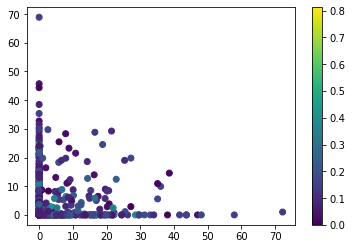

In [23]:
# Use encoder part of the autoencoder for feature selection
encoder = keras.Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
encoded_features_train = encoder.predict(fine_tune_train)
encoded_features_test = encoder.predict(fine_tune_test)

# Display the shape of extracted features
print("Encoded Features Shape (Train):", encoded_features_train.shape)
print("Encoded Features Shape (Test):", encoded_features_test.shape)
# plot all encoded features
plt.scatter(encoded_features_train[:,0], encoded_features_train[:,1], c = y_train['AAC'], cmap='viridis')
plt.colorbar()
plt.show()

In [24]:
# --- Encoded Features ---
# Fit a linear regression model using the encoded features
encoded_model = LinearRegression()
encoded_model.fit(encoded_features_train, y_train)

# Make predictions on the test set
y_pred_encoded = encoded_model.predict(encoded_features_test)

# Calculate regression metrics
mse_encoded = mean_squared_error(y_test, y_pred_encoded)
r2_encoded = r2_score(y_test, y_pred_encoded)

# Calculate Spearman's rank correlation for encoded features
spearman_encoded, p_value_encoded = spearmanr(y_test, y_pred_encoded)

print("--- Encoded Features ---")
print("Mean Squared Error (MSE):", mse_encoded)
print("R-squared (R²):", r2_encoded)
print("Spearman's Correlation (ρ):", spearman_encoded)
print("P-value (Spearman):", p_value_encoded)

--- Encoded Features ---
Mean Squared Error (MSE): 0.04208095010284664
R-squared (R²): -4.621226525503842
Spearman's Correlation (ρ): 0.18302392801016779
P-value (Spearman): 0.025471003963444098


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Normalize the data
scaler = MinMaxScaler()
new_X_train_scaled = scaler.fit_transform(extra_train)

# Convert to tensor
new_X_train_tensor = torch.tensor(new_X_train_scaled, dtype=torch.float32)
new_dataset = torch.TensorDataset(new_X_train_tensor)
new_train_loader = torch.DataLoader(new_dataset, batch_size=32, shuffle=True)
new_X_test_tensor = torch.tensor(scaler.transform(extra_test), dtype=torch.float32)
new_test_dataset = torch.TensorDataset(new_X_test_tensor)
new_test_loader = torch.DataLoader(new_test_dataset, batch_size=32, shuffle=False)

X_train_scaled = scaler.fit_transform(fine_tune_train)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
dataset = torch.TensorDataset(X_train_tensor)
train_loader = torch.DataLoader(dataset, batch_size=32, shuffle=True)

X_test_tensor = torch.tensor(scaler.transform(fine_tune_test), dtype=torch.float32)
test_dataset = torch.TensorDataset(X_test_tensor)
test_loader = torch.DataLoader(test_dataset, batch_size=32, shuffle=False)
input_dim = extra_train.shape[1]
latent_dim = 2
augmented_model = VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(augmented_model.parameters(), lr=1e-3)
train(augmented_model, new_train_loader,new_test_loader, optimizer, epochs=10, device=device)


Epoch 1/10, Train Loss: 1.6073, Val Loss: 0.2975
Epoch 2/10, Train Loss: 0.0940, Val Loss: 0.0343
Epoch 3/10, Train Loss: 0.0281, Val Loss: 0.0223
Epoch 4/10, Train Loss: 0.0206, Val Loss: 0.0181
Epoch 5/10, Train Loss: 0.0167, Val Loss: 0.0168
Epoch 6/10, Train Loss: 0.0143, Val Loss: 0.0116
Epoch 7/10, Train Loss: 0.0113, Val Loss: 0.0111
Epoch 8/10, Train Loss: 0.0105, Val Loss: 0.0098
Epoch 9/10, Train Loss: 0.0088, Val Loss: 0.0085
Epoch 10/10, Train Loss: 0.0076, Val Loss: 0.0074


In [26]:
# Fine-Tune the VAE
train(augmented_model, train_loader,test_loader, optimizer, epochs=20, device=device)

Epoch 1/20, Train Loss: 0.1036, Val Loss: 0.0767
Epoch 2/20, Train Loss: 0.0337, Val Loss: 0.0258
Epoch 3/20, Train Loss: 0.0123, Val Loss: 0.0153
Epoch 4/20, Train Loss: 0.0072, Val Loss: 0.0126
Epoch 5/20, Train Loss: 0.0053, Val Loss: 0.0110
Epoch 6/20, Train Loss: 0.0045, Val Loss: 0.0101
Epoch 7/20, Train Loss: 0.0038, Val Loss: 0.0097
Epoch 8/20, Train Loss: 0.0034, Val Loss: 0.0092
Epoch 9/20, Train Loss: 0.0031, Val Loss: 0.0089
Epoch 10/20, Train Loss: 0.0028, Val Loss: 0.0086
Epoch 11/20, Train Loss: 0.0026, Val Loss: 0.0086
Epoch 12/20, Train Loss: 0.0024, Val Loss: 0.0082
Epoch 13/20, Train Loss: 0.0023, Val Loss: 0.0081
Epoch 14/20, Train Loss: 0.0021, Val Loss: 0.0079
Epoch 15/20, Train Loss: 0.0020, Val Loss: 0.0078
Epoch 16/20, Train Loss: 0.0019, Val Loss: 0.0077
Epoch 17/20, Train Loss: 0.0018, Val Loss: 0.0075
Epoch 18/20, Train Loss: 0.0017, Val Loss: 0.0075
Epoch 19/20, Train Loss: 0.0016, Val Loss: 0.0074
Epoch 20/20, Train Loss: 0.0016, Val Loss: 0.0072


In [27]:
# Extract latent features from X_train
new_latent_train,_ = augmented_model.encode(X_train_tensor)
new_latent_test,_ = augmented_model.encode(X_test_tensor)
new_latent_train = new_latent_train.detach().numpy()
new_latent_test = new_latent_test.detach().numpy()
print(new_latent_train.shape) 

(593, 50)


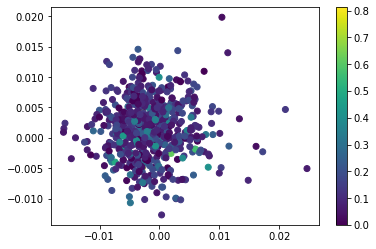

In [28]:
# plot all encoded features
plt.scatter(new_latent_train[:,0], new_latent_train[:,1], c = y_train['AAC'], cmap='viridis')
plt.colorbar()
plt.show()

In [29]:
vae_augmented_model = LinearRegression()
vae_augmented_model.fit(new_latent_train, y_train)
new_y_pred_vae = vae_augmented_model.predict(new_latent_test)
# Calculate regression metrics
mse_vae_augmented = mean_squared_error(y_test, new_y_pred_vae)
r2_vae_augmented = r2_score(y_test, new_y_pred_vae)
spearman_vae_augmented, p_value_vae_augmented = spearmanr(y_test, new_y_pred_vae)

# Print the results
print("--- VAE Encoded Features ---")
print("Mean Squared Error (MSE):", mse_vae_augmented)
print("R-squared (R²):", r2_vae_augmented)
print("Spearman's Correlation (ρ):", spearman_vae_augmented)

--- VAE Encoded Features ---
Mean Squared Error (MSE): 0.015442601678546079
R-squared (R²): -1.0628422591713584
Spearman's Correlation (ρ): 0.33455499234096137
